# Introduction

이 대회는 브라질에서 세번째로 큰 보험 회사인 포르투 세구로가 주최하며, 운전자가 내년에 보험 청구를 시작할 확률을 예측하는 임무를 맡고 있음

이 노트북은 python 시각화 라이브러리 plot.ly를 통해 대회 데이터에 대한 interactive 차트와 분석을 제공하고,

다른 사람들이 가져와서 복제할 수 있는 인사이트와 아름다운 플롯을 제공하는 것을 목표로 함.


1. Simple horizontal bar plot - 대상 변수 분포를 검사하는 데 사용
2. Correlation Heatmap plot - 다양한 특징 간의 상관관계 검사
3. Scatter plot - 랜덤 포레스트와 그래디언트 부스트 모델에서 생성된 특징 중요도 비교
4. Vertical bar plot - 내림차순으로 나열, 다양한 특징의 중요성
5. 3D Scatter plot

이 노트북의 주제를 요약하면 다음과 같음.
- 데이터 품질검사 - 누락된 / 누락된 모든 값 (-1)를 시각화하고 평가
- 특징 검사 및 필터링 - 목표 변수에 대한 상관관계 및 특징 상호 정보 플롯. 이진 변수, 범주형 변수 및 기타 변수의 검사
- 학습 모델을 통한 특징 중요도 순위 / n 랜덤 포레스트 및 그래디언트 부스트 모델 구축을 통해 학습과정을 기반으로 특징 순위를 매기는데 도움


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif # # 이산적인 목표 변수에 대한 상호 정보를 추정
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/porto-seguro-safe-driver-prediction/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows,columns))

The train dataset contains 595212 rows and 59 columns


# 1. Data Quality checks

## 1-1. Null or Missing values check
As part of out quality checks, let us quick look at whether there are any null values in the train dataset as follows

In [4]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

Null 값 검사는 False를 반환하지만, 이는 데이터가 -1값은 관측값에서 해당 feature이 누락되었음을 나타낸다고 설명되어 있기 때문에 실제로 Null 값이 없다고 반환하는 것이 아님.

단순히 데이터의 모든 Null값을 -1값으로 일괄교체 했다고 생각됨.

데이터에 누락된 값이 있는지 확인..

In [5]:
# -1값을 Null값으로 대체
train_copy = train
train_copy = train_copy.replace(-1, np.NAN)

데이터셋에서 누락된 값을 시각화하는 데 가장 유용하고 편리한 도구인 "missingno"패키지

<Axes: >

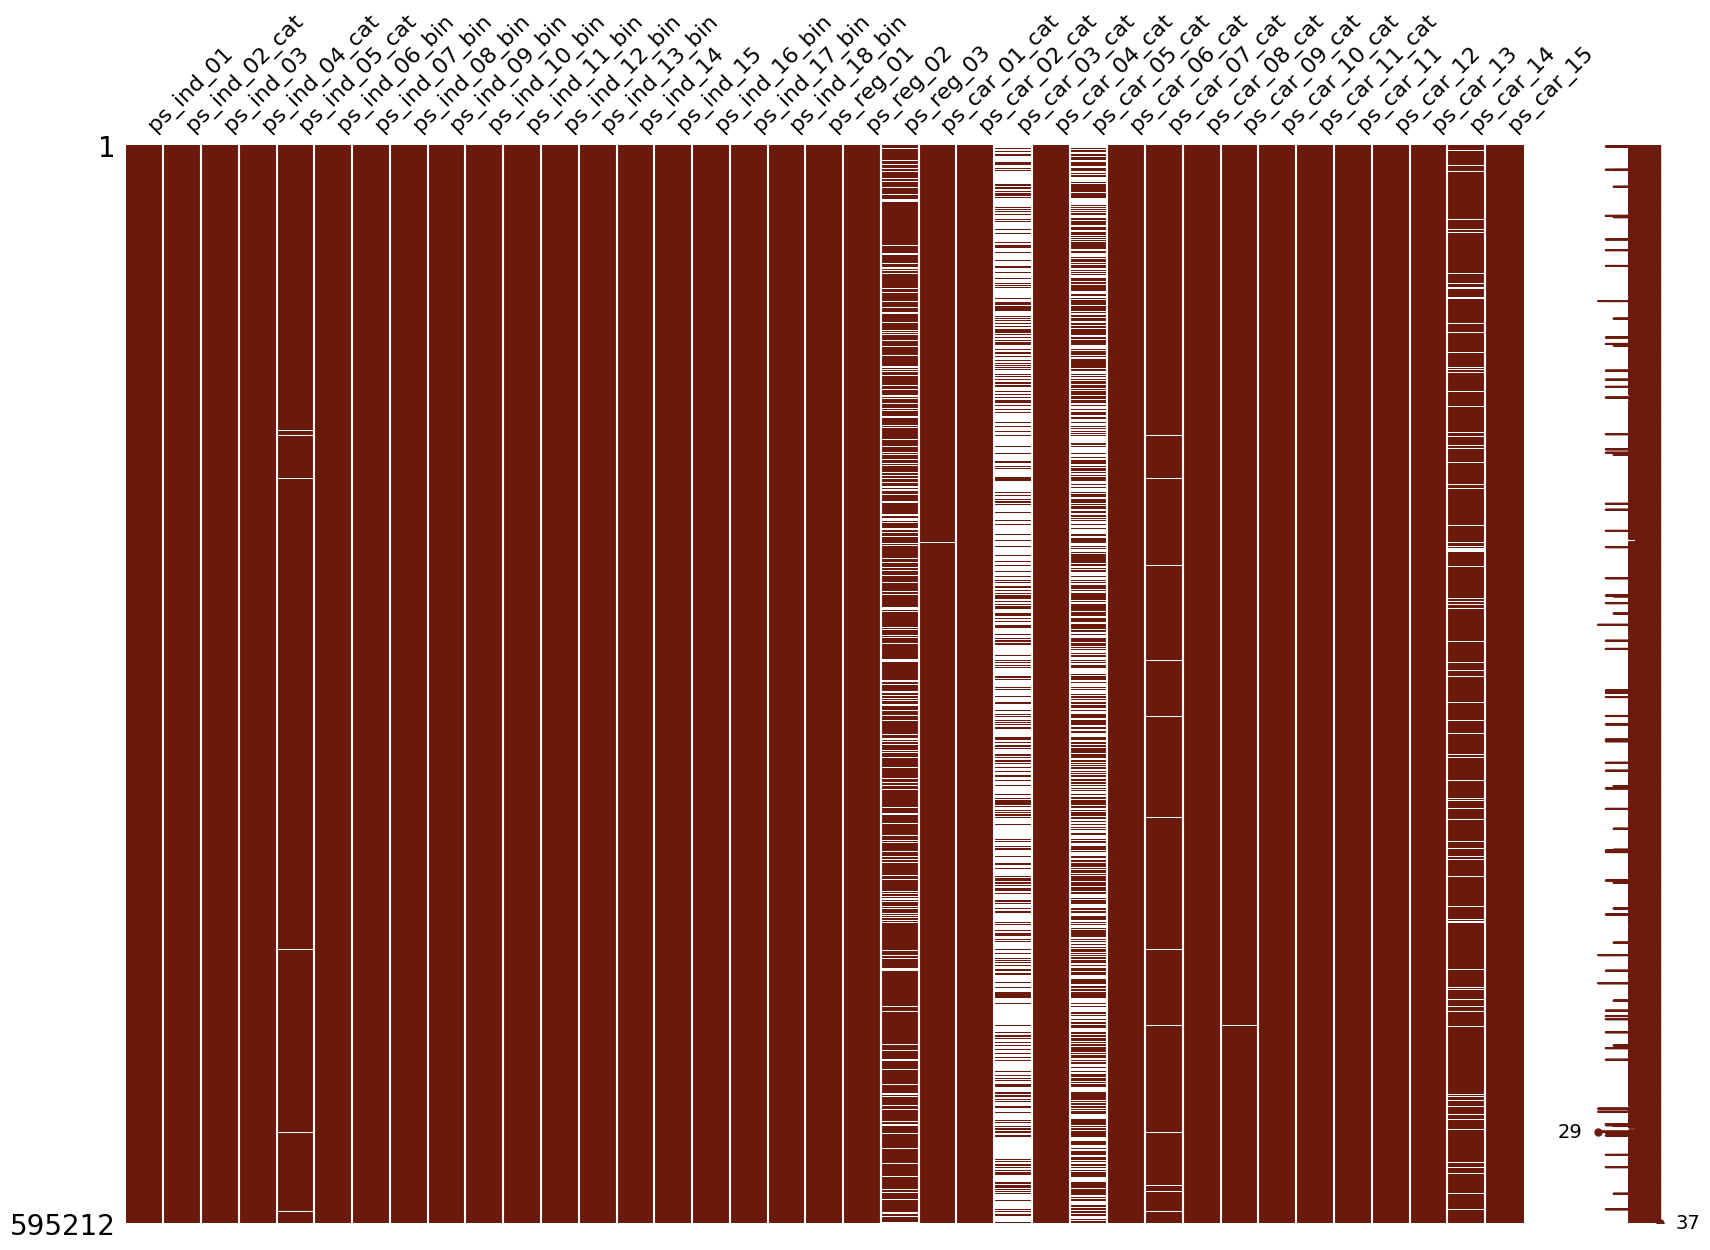

In [6]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39],figsize=(20,14),color=(0.42,0.1,0.05))

결측값은 시각화할 때 훨씬 더 명확해짐.

빈 흰색 띠(결측된 데이터)가 수직의 어두운 빨간색 띠(결측되지 않은 데이터)에 겹쳐져 해당열의 데이터가 무효임을 나타냄.

이 경우 59개의 feature중 7개의 feature이 실제로 무효값을 포함하고 있음을 알 수 있음.

(결측값이 있는 열은 총 13개로 구성)

이는 결측 행렬 플롯이 하나의 플롯에 약 40개의 홀수 feature만 편안하게 맞출 수 있고,

그 후 일부 열이 제외되어 나머지 5개의 무효열이 제외되었기 때문.

모든 무효값을 시각화하려면 그림 크기 인수를 변경하고 데이터 프레임을 슬라이스하는 방법을 조정해야함.



우리가 관찰할 수 있는 7개의 Null 열은 다음과 같음. :

**ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14**

대부분의 결측값은 _cat으로 둘러싸인 열에서 발생.

ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 주목해야함.

흰색과 어두운 띠의 비율에서 알 수 있듯 이 세열에서 대부분의 값이 결측된 것이 분명하므로,

널에 대해 -1을 일괄적으로 대체하는 것은 그다지 좋은 전략이 아닐 수 있음.

## 1-2. Target variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 목표 변수와 관련된 것.

이 경우 열은 편리하게 "target"이라는 제목으로 불림. 목표값은 class/label/correct answer라는 이름으로도 불리며,

지도 학습 모델에서 주어진 데이터와 함께 사용되어 학습된 함수가 새로운 미지의 데이터로 잘 일반화되고 예측할 수 있기를 바라며

데이터를 목표에 가장 잘 매핑하는 함수를 학습하는 데 사용.

In [7]:
data = [go.Bar(
    x = train["target"].value_counts().index.values,
    y = train["target"].value_counts().values,
    text = 'Distribution of target variable'
)]

layout = go.Layout(
    title = 'Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='basic-bar')
fig.show(renderer='iframe') # 이거 추가하니까 그려짐..

목표 변수가 다소 불균형적이기 때문에 염두에 두어야 할 사항일 수 있음.
불균형한 target은 꽤 잘 드러날 것임.

## 1-3. Datatype check

이 검사는 train데이터가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행.

integer, character, float, python시퀀스에서 고유한 유형의 카운틀를 얻는 요령은 다음과 같이 컬렉션 모듈을 가져올 때 카운터 메서드를 사용하는 것.

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급한 바와 같이, train 데이터셋을 구성하는 열은 총 59개이며, 이 검사에서 볼 수 있듯

feature/columns는 정수형과 실수형 두가지 데이터 유형으로만 구성되어 있음.

또 다른 주목할 점은 데이터 제공자가 실제로 "_bin", "_cat", "_reg"와 같은 약어로 둘러싸인 헤더를 제공했다는 점.

여기서 _bin은 binary 이진 feature을 나타내고, _cat은 category 범주형 feature를 나타내며,

나머지는 연속형 혹은 순서형 feature를 나타낸다는 설명을 제공했음.

여기서는 float값(아마도 연속형 feature만)과 integer 데이터 유형(이진형, 범주형 및 순서형 feature)만 살펴보는 것으로 이를 좀 더 단순화 함.

In [9]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

# 2. Correlation plots

우선 함수가 다음 함수와 어떻게 선형적으로 상관되는지 살펴보고, 여기서 통찰력을 얻기 위해 선형 상관관계 그래프를 생성해 보도록 함.

Seaborn을 사용하여 상관관계 히트맵을 그림.

## 2-1. Correlation of float features

<Axes: title={'center': 'Pearson corelation of continuous features'}>

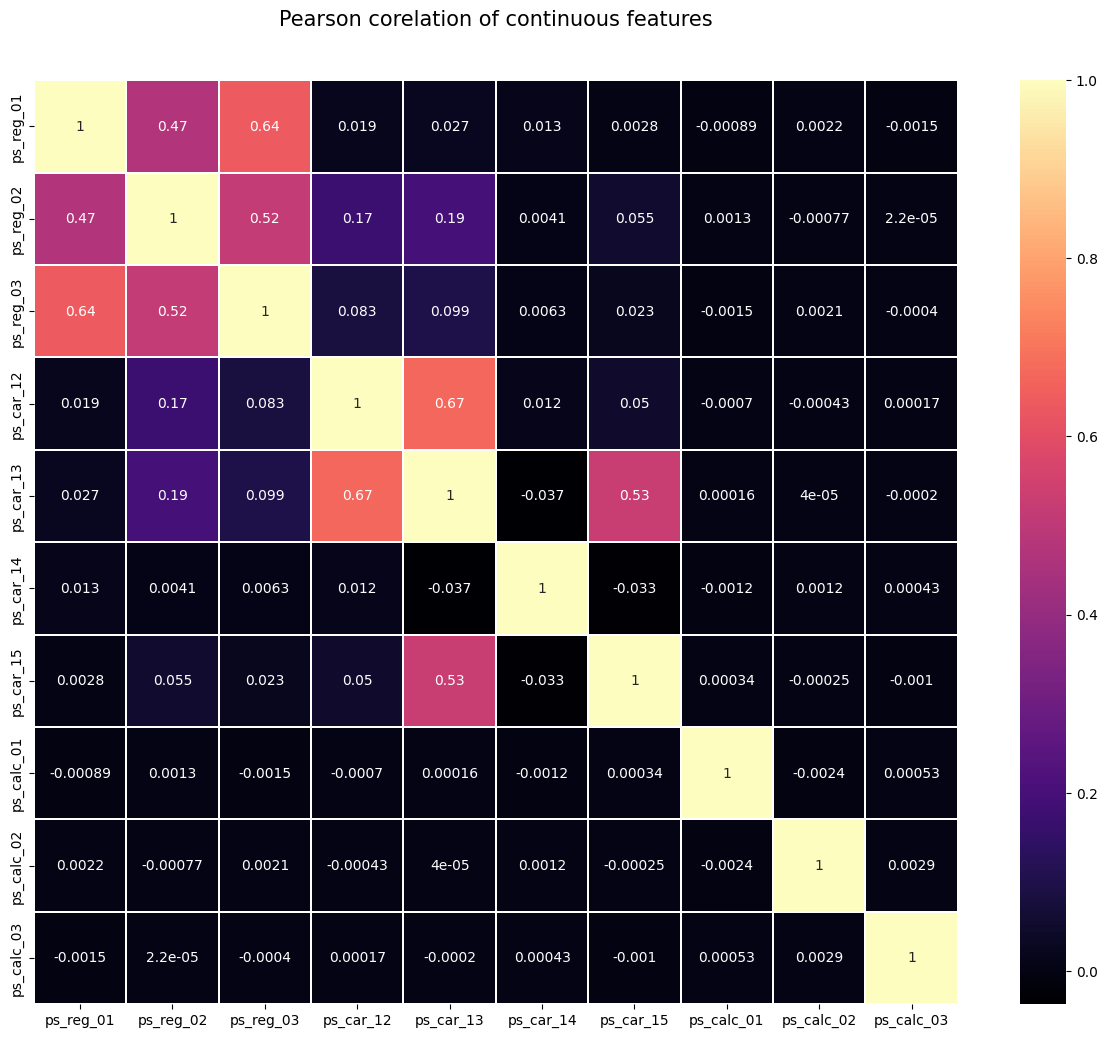

In [10]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson corelation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1,  vmax=1.0, square=True,
           cmap=colormap, linecolor='white', annot=True)

상관관계 그래프에서 대부분의 feature가 서로 상관관계가 없거나 전혀 없음을 알 수 있음.

현재로서는 양의 선형관계를 나타내는 쌍을 이루는 feature는 다음과 같음.


**(ps_reg_01, ps_reg_03)**

**(ps_reg_02, ps_reg_03)**

**(ps_car_12, ps_car_13)**

**(ps_car_13, ps_car_15)**


## 2-2. Correlation of integer features

plotly 라이브러리를 사용하여 상호작용적으로 상관관계 값의 히트맵을 생성하는 방법.

이전 plotly 플롯과 마찬가지로 "go.Heatmap"을 호출하여, 히트맵 객체를 생성.

여기서 우리는 x축과 y축이 열 이름을 입력하고 상관관계 값은 z축이 제공하는 세가지 축에 값을 제공해야 함.

colorsclae속성은 히트맵에서도 볼 수 있는 다양한 색상 팔레트에 해당하는 키워드를 입력받음.